<a href="https://colab.research.google.com/github/Elhai12/SBA_loans_predict/blob/main/Model_selection%26Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Clone git to get the files
!git clone https://github.com/Elhai12/SBA_loans_predict.git

Cloning into 'SBA_loans_predict'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 194 (delta 58), reused 24 (delta 24), pack-reused 113 (from 1)
Receiving objects: 100% (194/194), 32.32 MiB | 21.80 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')
import time
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.subplots as sp
from scipy.stats import mannwhitneyu,chisquare,chi2_contingency
import plotly.express as px
from SBA_loans_predict import Functions_for_EDA
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import f1_score,roc_auc_score,r2_score,accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


In [ ]:
df_for_models = pd.read_pickle('/content/SBA_loans_predict/data_files/data_after_feat_eng.pkl')

#Model Selction

In [ ]:
#Create function for show the performance of the models
def performance_model(y,y_pred):
  auc = roc_auc_score(y,y_pred)
  print(f'AUC: {auc}')
  f1 = f1_score(y,y_pred)
  print(f'F1 Score: {f1}')
  accuracy = accuracy_score(y,y_pred)
  print(f'Accuracy: {accuracy}')
  report = classification_report(y,y_pred)
  print(report)

  conf_matrix = confusion_matrix(y,y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [1,0])
  cm_display.plot()
  plt.show()
  return auc,f1,accuracy



In [ ]:
#Check Imbalanced
df_counts = pd.DataFrame(df_for_models['MIS_Status'].value_counts())
df_counts['prc'] = round(df_counts['count']/df_counts['count'].sum(),3)
df_counts

,count,prc
MIS_Status,,
1,29938,0.726
0,11274,0.274


In [ ]:
#Define X and y and split for train and test
X = df_for_models.drop('MIS_Status',axis=1)
y = df_for_models['MIS_Status']

X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.2,random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)


****************************** Model: SVC ******************************
AUC: 0.7320180932909462
F1 Score: 0.8887142408047783
Accuracy: 0.8282387190684134
              precision    recall  f1-score   support

           0       0.78      0.52      0.62      1132
           1       0.84      0.95      0.89      2990

    accuracy                           0.83      4122
   macro avg       0.81      0.73      0.76      4122
weighted avg       0.82      0.83      0.82      4122



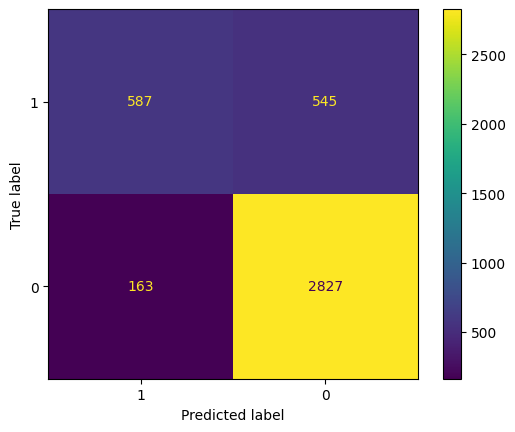

******************************************************************************************
****************************** Model: Logistic ******************************
AUC: 0.7480136970112388
F1 Score: 0.8925855513307985
Accuracy: 0.8355167394468704
              precision    recall  f1-score   support

           0       0.78      0.55      0.65      1132
           1       0.85      0.94      0.89      2990

    accuracy                           0.84      4122
   macro avg       0.82      0.75      0.77      4122
weighted avg       0.83      0.84      0.83      4122



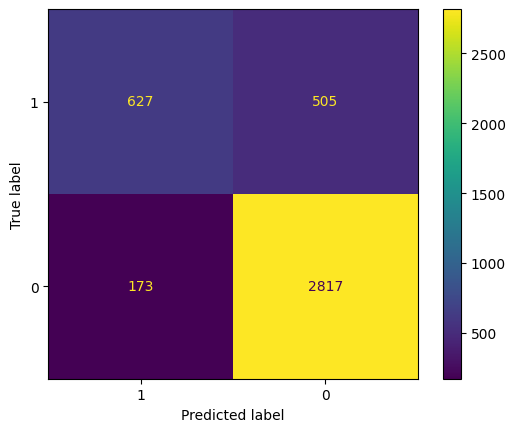

******************************************************************************************
****************************** Model: RandomForest ******************************
AUC: 0.891833792263966
F1 Score: 0.9486504279131007
Accuracy: 0.9243085880640466
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1132
           1       0.93      0.96      0.95      2990

    accuracy                           0.92      4122
   macro avg       0.91      0.89      0.90      4122
weighted avg       0.92      0.92      0.92      4122



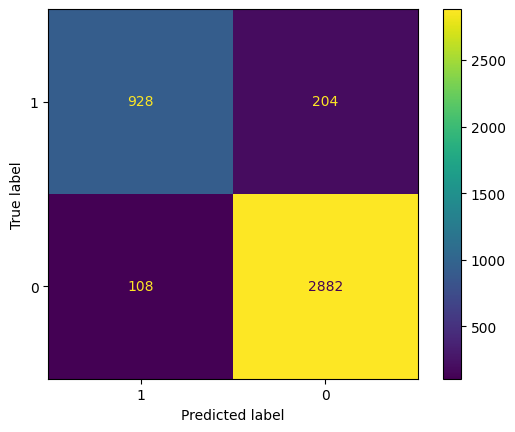

******************************************************************************************
****************************** Model: GradientBoost ******************************
AUC: 0.8966797452048643
F1 Score: 0.9494549058473737
Accuracy: 0.925764192139738
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1132
           1       0.94      0.96      0.95      2990

    accuracy                           0.93      4122
   macro avg       0.91      0.90      0.90      4122
weighted avg       0.92      0.93      0.92      4122



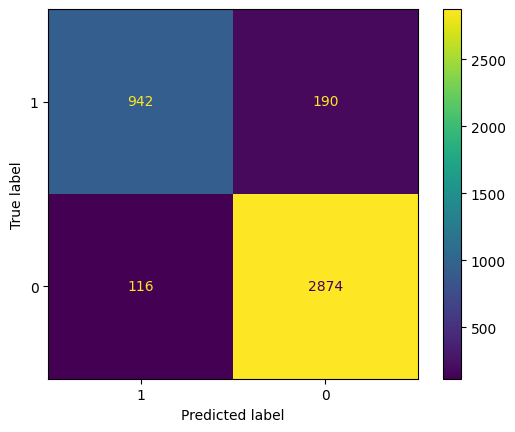

******************************************************************************************
****************************** Model: XGB ******************************
AUC: 0.906838755805571
F1 Score: 0.9530757751616648
Accuracy: 0.9313440077632217
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1132
           1       0.95      0.96      0.95      2990

    accuracy                           0.93      4122
   macro avg       0.92      0.91      0.91      4122
weighted avg       0.93      0.93      0.93      4122



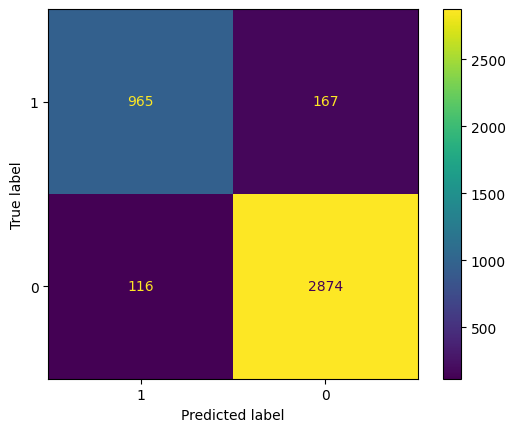

******************************************************************************************


In [ ]:
#Create dictionary of the models
models_dict = {'SVC':LinearSVC(random_state=42),
               'Logistic':LogisticRegression(random_state=42),
               'RandomForest':RandomForestClassifier(random_state=42),
               'GradientBoost':GradientBoostingClassifier(random_state=42),
               'XGB':xgb.XGBClassifier(random_state=42)
               }
dict_results = {}

#Loop for show the result for each model and save to dictionary for create df
for model_name,model in models_dict.items():
  print("***"*10,f'Model: {model_name}',"***"*10)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_val)
  auc,f1,acc = performance_model(y_val,y_pred)
  dict_results[model_name]={"AUC":auc,"F1":f1,"Accuracy":acc}
  print("***"*30)


In [ ]:
#Create df of the main results
df_results = pd.DataFrame(dict_results).T
#I chhose highlite the AUC column because this is indicate for the all tresholds, but f1 and accuracy is define by defualt treshold of 0.5
df_results_color = Functions_for_EDA.highlight_max_in_columns(df_results,'AUC',"green")
df_results_color

,AUC,F1,Accuracy
SVC,0.732018,0.888714,0.828239
Logistic,0.748014,0.892586,0.835517
RandomForest,0.891834,0.948650,0.924309
GradientBoost,0.896680,0.949455,0.925764
XGB,0.906839,0.953076,0.931344


The model was choosen is XGBoost

#Finetuning

In [23]:
#The paramter for grid search
parm_grid = {'n_estimators':[200,220,250],
             "eta": np.arange(0.3,0.45,0.01),
             "gamma": np.arange(0.1,0.28,0.01),
             "max_depth":[5,6,7],
             "subsample": np.arange(0.7,0.82,0.01),
             "min_child_weight":range(85,95,5)
}

#Define the model
xgb_model = xgb.XGBClassifier()

#Define function to score - by val dataset
def scorrer_for_val(model,X_val,y_val):
  y_pred = model.predict(X_val)
  auc = roc_auc_score(y_val,y_pred)
  return auc

#Get the best score by the function defined above
best_score = make_scorer(scorrer_for_val,greater_is_better=True)

#Define the grid search
grid_search = RandomizedSearchCV(xgb_model,param_distributions=parm_grid,n_iter=20, cv=5,scoring=best_score)
grid_search.fit(X_train,y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'subsample': np.float64(0.7), 'n_estimators': 250, 'min_child_weight': 90, 'max_depth': 5, 'gamma': np.float64(0.15999999999999998), 'eta': np.float64(0.4000000000000001)}
Best Score: nan


AUC: 0.911416407061267
F1 Score: 0.9538052509139249
Accuracy: 0.9325406454743994
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1125
           1       0.95      0.96      0.95      2996

    accuracy                           0.93      4121
   macro avg       0.92      0.91      0.91      4121
weighted avg       0.93      0.93      0.93      4121



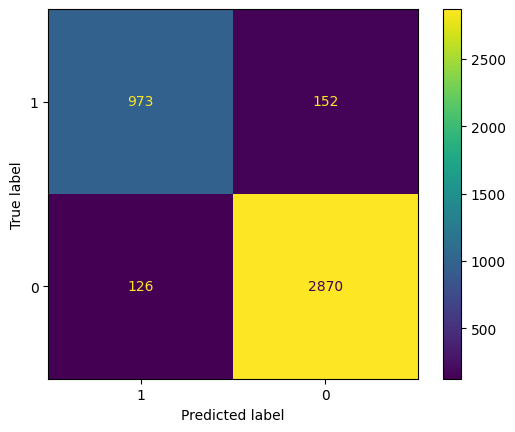

(np.float64(0.911416407061267), 0.9538052509139249, 0.9325406454743994)

In [24]:
y_pred_test = grid_search.predict(X_test)
performance_model(y_test,y_pred_test)